# 第5章 誤差逆伝播法
* 前章では重みパラメータの勾配（重みパラメータに関する損失関数の勾配）を数値微分で決定した．
* 数値微分は簡単だが計算に時間がかかる
* 本章では重みパラメータの効率良い計算法として「誤差逆伝播法」について学ぶ
* 誤差逆伝播法を理解する方法
  * 数式による方法：一般的な方法．厳密で簡潔．
  * 計算グラフ（computational graph）による方法：視覚的，分かりやすい．
    * [Hacker's guide to Neural Networks](http://karpathy.github.io/neuralnets/)
    * [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io)

## 5.1 計算グラフ

* 計算グラフとは，計算の過程をグラフで表したもの
  * グラフとは，複数のノードとエッジ（ノード間を結ぶ直線）によって表現される，データ構造としてのグラフ

### 5.1.1 計算グラフで解く

問1：太郎くんはスーパーで1個100円のリンゴを2個買いました．支払う金額を求めなさい．ただし，消費税が10％適用されるものとします．

* 計算グラフはノードと矢印で計算過程を表す．
* ノードは○で表記し，○の中に演算の内容を書く
* 計算の途中結果を矢印の上部に書くことで，ノードごとの計算結果が左から右へ伝わるように表す

<img src="./fig5_1.png">

```
# http://viz-js.com/
digraph G {
    rankdir=LR;
    node [shape=circle]
    n0 [label="リンゴ"]
    n1 [label="×2"]
    n2 [label="×1.1"]
    n3 [label="合計"]

    n0 -> n1 [label="100"]
    n1 -> n2 [label="200"]
    n2 -> n3 [label="220"]
}
```

* 最初にリンゴの100円が「×2」ノードへ流れ，200円になって次のノードの伝達される
* その200円が「×1.1」ノードへ流れ，220円になる
* この計算グラフの結果から答えは220円になる

#### 別の書き方

<img src="./fig5_2.png">

```
# http://viz-js.com/
digraph G {
    rankdir=LR;
    node [shape=circle]
    n0 [label="リンゴ"]
    n01 [label="リンゴ\nの個数"]
    n1 [label="×"]
    n11 [label="消費税"]
    n2 [label="×"]
    n3 [label="合計"]

    n0 -> n1 [label="100"]
    n01 -> n1 [label="2"]
    n1 -> n2 [label="200"]
    n11 -> n2 [label="1.1"]
    n2 -> n3 [label="220"]
}
```

問2：太郎くんはスーパーでリンゴを2個，みかんを3個買いました．リンゴは1個100円，みかんは1個150円です．消費税が10％かかるものとして，支払う金額を求めなさい．

<img src="./fig5_3.png">

```
# http://viz-js.com/
digraph G {
    rankdir=LR;
    node [shape=circle]
    n00 [label="リンゴ"]
    n01 [label="リンゴ\nの個数"]
    n03 [label="みかん\nの個数"]
    n02 [label="みかん"]

    n10 [label="×"]
    n11 [label="×"]
    
    n20 [label="+"]
    n21 [label="消費税"]

    n3 [label="×"]
    n4 [label="合計"]

    n00 -> n10 [label="100"]
    n01 -> n10 [label="2"]
    n02 -> n11 [label="150"]
    n03 -> n11 [label="3"]
    
    n10 -> n20 [label="200"]
    n11 -> n20 [label="450"]

    n20 -> n3 [label="650"]
    n21 -> n3 [label="1.1"]
    n3 -> n4 [label="715"]
}
```

#### 計算グラフまとめ

* 計算グラフを使って問題を解く流れ
    1. 計算グラフを構築する
    2. 計算グラフ上で計算を左から右へ進める（順伝播 forward propagation という）   

### 5.1.2 局所的な計算

* 計算グラフの特徴は「局所的な計算」を伝播することにより最終的な結果を得ることができる点
  * 局所的とは「自分（ノード）に関係する小さな範囲」ということ．それ以外は気にしない
  * 局所的な計算とは「自分（ノード）への入力だけからその結果を出力する」ということ
* 全体では複雑な計算であったとしても，分割して単純な局所的計算の集まりにでき，それぞれは個々の計算に集中できる

### 5.1.3 なぜ計算グラフで解くのか？

* 計算グラフの利点
  * 局所的な計算．分割して個々の問題を単純にする．
  * 途中の計算結果を保持できる
  * **逆方向の伝播によって「微分」を効率良く計算できる**

* ここで問1の場合での微分とは何かを考えてみる
  * 合計をりんごの値段で微分する場合（つまり，「りんごの値段に関する合計金額の微分」を求める）
  * 記号で表現すると「合計金額を$L$,りんごの値段を$x$とするとき$\frac{\partial L}{\partial x}$を求める」ことになる
* 微分は逆方向の伝播で計算することができる
  * 逆伝播は逆向きの矢印で表現する
  * 逆伝播は局所的な微分を表す
  * この図の場合，りんごを指す矢印の数値は2.2になる．これは微分が2.2であることを表す．
    * つまり，りんごが1円値上がりしたら支払い金額は2.2円増える

<img src="./fig5_4.png">

```
digraph G {
    rankdir=LR;
    node [shape=circle]
    n0 [label="リンゴ"]
    n01 [label="リンゴ\nの個数"]
    n1 [label="×",color="gray"]
    n11 [label="消費税"]
    n2 [label="×",color="gray"]
    n3 [label="合計"]

    n0 -> n1 [label="100",color="gray"]
    n01 -> n1 [label="2",color="gray"]
    n1 -> n2 [label="200",color="gray"]
    n11 -> n2 [label="1.1",color="gray"]
    n2 -> n3 [label="220",color="gray"]

    n3 -> n2 [label="1",style="bold",color="red"]
    n2 -> n1 [label="1.1",style="bold",color="red"]
    n1 -> n0 [label="2.2",style="bold",color="red"]
}
```

## 5.2 連鎖律

* 「局所的な微分」を伝達する原理は**連鎖率(chain rule)**による

### 5.2.1 計算グラフの逆伝播

#### 逆伝播の計算

* 信号Eに，関数$f=y(x)$の微分$\frac{\partial y}{\partial x}$を乗算して前のノードへ渡す
* これで微分値が効率よく求められる理由は連鎖率の原理にある(次節で説明)

<img src="fig5_5.png">

### 5.2.2 連鎖律とは

#### 合成関数

* 合成関数とは，複数の関数によって構成される関数のこと
  * たとえば $z={(x+y)}^2$ という式は次の2つの式で構成される
    * $z=t^2$
    * $t=x+y$

#### 連鎖律

連鎖律とは，合成関数の微分についての性質のこと

#### 連鎖律の原理

* ある関数が合成関数で表される場合，その合成関数の微分は，合成関数を構成するそれぞれの関数の微分の席によって表すことができる
  * $\frac{\partial z}{\partial x}$ は$\frac{\partial z}{\partial t}$と$\frac{\partial t}{\partial x}$の席で表すことができるということ
$$\frac{\partial z}{\partial x} 
= \frac{\partial z}{\partial t}\frac{\partial t}{\partial x}$$
先の例では$\frac{\partial z}{\partial t}=2t$,$\frac{\partial t}{\partial x}=1$が解析的に得られたため
$$\frac{\partial z}{\partial x} = 2(x+y)$$

### 5.2.3 連鎖律と計算グラフ

$t=(x+y)^2$をノードで表してみる

<img src="fig5_6.png">

* 逆伝播は右から左へと信号が伝播する
* 各ノードはそれまでの偏微分の積を受け取り，それに自ノードの偏微分を積算して次（前段）のノードへ送る
* 自ノードの偏微分を積算することで，最終出力を自ノードの入力で偏微分した結果が得られることになる

## 5.3 逆伝播

### 5.3.1 加算ノードの逆伝播

$\frac{\partial z}{\partial x}=1$, $\frac{\partial z}{\partial y}=1$であるため，上流から伝わった微分を$\frac{\partial L}{\partial z}$とすると次のようになる．

<img src="fig5_7.png">

つまり，加算ノードの逆伝播は入力の内容をそのまま出力するだけ．

```
digraph G {
    rankdir=LR;
    node [shape=circle]
    n0 [label="", color="none"]
    n01 [label="", color="none"]
    n1 [label="+",color="gray"]
    n2 [label="",color="none"]

    { rank = same;
        "n0", "n01";
    }

    n0 -> n1 [label="x",color="gray"]
    n01 -> n1 [label="y",color="gray"]
    n1 -> n2 [label="z",color="gray"]

    n1 -> n0 [label="dL/dz・1 ",style="bold",color="red"]
    n1 -> n01 [label="dL/dz・1 ",style="bold",color="red"]
    n2 -> n1 [label="dL/dz",style="bold",color="red"]
}
```

### 5.3.2 乗算ノードの逆伝播

$\frac{\partial z}{\partial x}=y$, $\frac{\partial z}{\partial y}=x$であるため，上流から伝わった微分を$\frac{\partial L}{\partial z}$とすると次のようになる．

<img src="fig5_8.png">

乗算ノードの逆伝播は入力の内容に入力をひっくり返した値を乗算して出力する．
（多入力の乗算の場合は？2入力の乗算に分解すればいいということか）

### 5.3.3 リンゴの例

先のりんごとみかんの例について逆伝播をためしてみる．

<img src="fig5_9.png">

```
# http://viz-js.com/
digraph G {
    rankdir=LR;
    node [shape=circle]
    n00 [label="リンゴ"]
    n01 [label="リンゴ\nの個数"]
    n03 [label="みかん\nの個数"]
    n02 [label="みかん"]

    n10 [label="×"]
    n11 [label="×"]

    n20 [label="+"]
    n21 [label="消費税"]

    n3 [label="×"]
    n4 [label="合計"]

    { rank = same; "n00", "n01", "n02", "n03"; }
    { rank = same; "n10", "n11"; }
    { rank = same; "n20", "n21"; }
    { rank = same; "n3"; }
    { rank = sink; "n4"; }

    n00 -> n10 [label="100"]
    n01 -> n10 [label="2"]
    n02 -> n11 [label="150"]
    n03 -> n11 [label="3"]
    n10 -> n20 [label="200"]
    n11 -> n20 [label="450"]
    n20 -> n3 [label="650"]
    n21 -> n3 [label="1.1"]
    n3 -> n4 [label="715"]

    n4 -> n3 [label="1", color="red", style="bold"]
    n3 -> n20 [label="1.1", color="red", style="bold"]
    n3 -> n21 [label="650", color="red", style="bold"]
    n20 -> n10 [label="1.1", color="red", style="bold"]
    n20 -> n11 [label="1.1", color="red", style="bold"]
    n10 -> n00 [label="2", color="red", style="bold"]
    n10 -> n01 [label="110", color="red", style="bold"]
    n11 -> n02 [label="3.3", color="red", style="bold"]
    n11 -> n03 [label="165", color="red", style="bold"]
}
```

## 5.4 単純なレイヤの実装

### 5.4.1 乗算レイヤの実装

In [58]:
# 乗算レイヤの実装
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy


In [59]:
# 乗算レイヤを使ったりんごの例を計算してみる
apple = 100
apple_num = 2
tax = 1.1

# layer の定義
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [60]:
# りんごの例で，逆伝播から微分を求めてみる
# dapple_price, dtax はそれぞれ apple_price, tax の微分を表す
dprice = 1

# 呼び出す順番は forward の時と逆の順番で行う
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


### 5.4.2 加算レイヤの実装

In [61]:
# 加算レイヤの実装
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [6]:
# りんごとみかんの買い物の例を実装する
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer の定義
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

print(price)

715.0000000000001


In [7]:
# 微分を計算してみる

dprice = 1

# backword
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(dapple, dapple_num, dorange, dorange_num, dapple_price, dorange_price, dall_price, dtax)



2.2 110.00000000000001 3.3000000000000003 165.0 1.1 1.1 1.1 650


## 5.5 活性化関数レイヤの実装

### 5.5.1 ReLUレイヤ

ReLU(Rectified Linear Unit) の式

$$y = \left\{ 
    \begin{array}{ll}
        x & (x>0) \\
        0 & (x \leq 0) \\
    \end{array} \right.
$$
ここで$y$を$x$で偏微分すると
$$\frac{\partial y}{\partial x} = \left\{ 
    \begin{array}{ll}
        1 & (x>0) \\
        0 & (x \leq 0) \\
    \end{array} \right.
$$



In [8]:
import numpy as np

In [9]:
# ReLUレイヤの実装
# ここで forward および backward にはNumPyの配列が入力されることを想定する

class Relu:
    def __init__(self):
        # マスクされる要素のインデックスのみTrueでそれ以外はFalseのNumpy配列
        self.mask = None
    
    # 入力xの要素のうち，0以下の要素のみ0にして出力する
    def forward(self, x):
        # 0以下の値を持つ要素のみTrueを持つ配列を作る
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        # doutの中で，マスクする要素のみ0にする．それ以外はそのままの値とする
        dout[self.mask] = 0
        dx = dout
        
        return dx

### 5.5.2 Sigmoidレイヤ

シグモイド関数の定義
$$y=\frac{1}{1+\exp (-x)}$$

およびその偏微分は次のようになる．
$$\frac{\partial y}{\partial x}=y^2\exp(-x)$$

この関数の計算グラフおよび微分を計算すると，次のようになる
<img src="fig5_10.png">
出力$y$の$x$による偏微分の式は$x$と$y$のみからなるため，次のように計算グラフを簡略化できる
<img src="fig5_11.png">

さらに式を変形する

$$
\begin{array}{ll}
\frac{\partial L}{\partial y}y^2\exp(-x) &=& \frac{\partial L}{\partial y}\frac{1}{(1+\exp(-x))^2}\exp(-x) \\
&=& \frac{\partial L}{\partial y}\frac{1}{1+\exp(-x)}\frac{\exp(-x)}{1+\exp(-x)} \\
&=& \frac{\partial L}{\partial y}{y(1-y)} 
\end{array}
$$

つまり，Sigmoid関数の微分は順方向の出力値だけを使って計算することができる
<img src="fig5_12.png">


In [10]:
# Sigmoidレイヤの実装
# ここで forward および backward にはNumPyの配列が入力されることを想定する

class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1/(1+np.exp(-x))
        #　逆伝播のときに使えるよう記憶しておく
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

## 5.6 Affine/Softmaxレイヤの実装

### 5.6.1 Affineレイヤ



### 5.6.2 バッチ版Affineレイヤ

In [11]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        
        out = np.dot(self.x, self.W) + self.b
        
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

In [13]:
import numpy as np

In [47]:
# テンソル対応でやってること
# 本では3次元以上の配列のことをテンソルと呼んでいた
# 例として4次元配列を与えてみる
X = np.array([[[[1,2],[3,4],[5,6]],[[4,5],[6,7],[8,9]]],[[[1,2],[3,4],[5,6]],[[4,5],[6,7],[8,9]]]])
print(X)
print(X.shape)
# 一番外側の要素の個数
print(X.shape[0])
# 強制的に2次元配列にする．第2引数で-1を指定すると，第1引数を元に自然な形状の配列を作る
print(X.reshape(X.shape[0],-1))
print(X.reshape(X.shape[0],-1).shape)

[[[[1 2]
   [3 4]
   [5 6]]

  [[4 5]
   [6 7]
   [8 9]]]


 [[[1 2]
   [3 4]
   [5 6]]

  [[4 5]
   [6 7]
   [8 9]]]]
(2, 2, 3, 2)
2
[[1 2 3 4 5 6 4 5 6 7 8 9]
 [1 2 3 4 5 6 4 5 6 7 8 9]]
(2, 12)


### 5.6.3 Softmax-with-Lossレイヤ

In [50]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## 5.7 誤差逆伝播法の実装

### 5.7.1 ニューラルネットワークの学習の全体図

### 5.7.2 誤差逆伝播法に対応したニューラルネットワークの実装

In [65]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
#from deep_learning_from_scratch.common.layers import *
from deep_learning_from_scratch.common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
        # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    

### 5.7.3 誤差逆伝播法の勾配確認

In [71]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    
    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


In [72]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from deep_learning_from_scratch.dataset.mnist import load_mnist
#from deep_learning_from_scratch.ch05.two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:2.38283401145e-13
b1:9.48171263726e-13
W2:8.13011583756e-13
b2:1.19459989123e-10


### 5.7.4 誤差逆伝播法を使った学習

In [74]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from deep_learning_from_scratch.dataset.mnist import load_mnist
#from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 学習履歴
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.1407 0.1424
0.90615 0.9085
0.92475 0.9258
0.933266666667 0.9343
0.944533333333 0.9435
0.950683333333 0.9494
0.956583333333 0.9535
0.961516666667 0.9578
0.9648 0.9601
0.967933333333 0.9636
0.969683333333 0.9654
0.972783333333 0.967
0.973083333333 0.9665
0.9744 0.9686
0.976216666667 0.9693
0.977383333333 0.9708
0.9789 0.9705


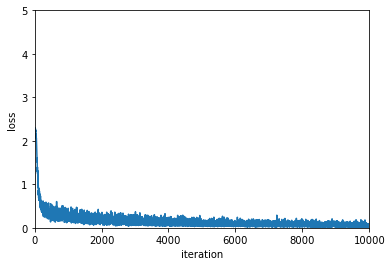

In [76]:
import matplotlib.pyplot as plt

# 損失関数の推移をグラフに描画して，徐々に下がっていくことを確認
x = np.arange(iters_num)
plt.plot(x, train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.xlim(0, 10000)
plt.ylim(0, 5)
plt.show()

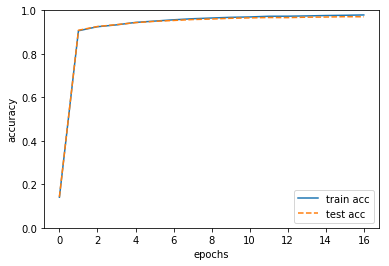

In [77]:
# 認識精度の推移をグラフに描画し，認識精度が上がっていることを確認
# 計算自体は先のプログラムで行なっているため，ここではプロットのみ
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 5.8 まとめ

* 視覚的に計算の価値を表す計算グラフを学んだ
* 計算グラフを用いてニューラルネットワークで行う逆誤差伝搬法を説明し，ニューラルネットワークで行う処理をレイヤという単位で実装した
    * ReLUレイヤ，Softmax-with-Lossレイヤ，Affineレイヤ，Softmaxレイヤ
    * レイヤにはforwardとbackwardというメソッドが実装されている
    * データを順方向と逆方向に伝搬することで重みパラメータの勾配を効率的に求めることができる
* レイヤによるモジュール化によりレイヤを自由に組み合わせることができ，好きなネットワークを簡単に作ることができる

* 計算グラフを用いると計算過程を簡単に把握できる
* 計算グラフのノードは局所的な計算により構成される．局所的な計算が全体の計算を構成する．
* 計算グラフの順伝搬は通常の計算を行う．
* 計算グラフの逆伝搬によって微分を求めることができる
* ニューラルネットワークの構成要素をレイヤとして実装することで，勾配計算を効率的に求めることができる（逆誤差伝搬法）
* 数値微分と逆誤差伝搬法の結果を比較することで，逆誤差伝搬法の実装に誤りがないことを確認することができる（勾配確認）